# Data Preprocessing

In [ ]:
customer_df = pd.read_csv('customer_df.csv')

In [ ]:
customer_df.shape

(110518, 15)

## Fonctions utilisées

In [ ]:
# Fonctions pour representation graphique

def correlation_graph_interactive(pca, x_y, features,labels=False):
    # Extraire x et y
    x, y = x_y

    # Créer une figure
    fig =  go.Figure()

    # For each component:
    for i in range(0, pca.components_.shape[1]):
        # Créer des annotations de flèches pour les composants
        fig.add_trace(go.Scatter(
            x=[0, pca.components_[x, i]],
            y=[0, pca.components_[y, i]],
            mode='lines+markers+text',
            marker=dict(size=10),
            line=dict(width=2),
            # text=[features[i]]*2,
            # textposition='top center',
            name=f"{features[i]}",
            hovertext=f"{features[i]}: ({pca.components_[x, i]:.2f}, {pca.components_[y, i]:.2f})")
        )
      # Ajouter des annotations pour chaque étiquette afin d'éviter les chevauchements
        if labels:
          fig.add_annotation(
            x=pca.components_[x, i] + (0.1 if pca.components_[x, i] >= 0 else -0.1),
            y=pca.components_[y, i] + (0.1 if pca.components_[y, i] >= 0 else -0.1),
            text=features[i],
            showarrow=False,
            font=dict(size=10),
            bgcolor='rgba(255, 255, 255, 0.7)',
            bordercolor='black'
        )

    # Ajouter des lignes horizontales et verticales
    fig.add_shape(type="line", x0=-1, x1=1, y0=0, y1=0, line=dict(color="grey", dash="dash"))
    fig.add_shape(type="line", x0=0, x1=0, y0=-1, y1=1, line=dict(color="grey", dash="dash"))

    # Ajouter le cercle d'unité pour l'échelle
    theta = np.linspace(0, 2 * np.pi, 100)
    circle_x = np.cos(theta)
    circle_y = np.sin(theta)
    fig.add_trace(go.Scatter(x=circle_x, y=circle_y, mode="lines", name="Unit Circle"))

    # Définir les titres des axes avec le pourcentage de variance expliquée
    fig.update_xaxes(title_text=f'PC{x+1} ({round(100*pca.explained_variance_ratio_[x], 1)}%)')
    fig.update_yaxes(title_text=f'PC{y+1} ({round(100*pca.explained_variance_ratio_[y], 1)}%)')

    # Définir le titre
    fig.update_layout(title_text=f"Cercle des corrélations  (PC{x+1} et PC{y+1})", showlegend=False)

    # # Si une representation sous forme d'un cercle est voulu
    # fig.update_layout(
    #     title_text=f"Correlation Circle (PC{x+1} and PC{y+1})",
    #     showlegend=True,
    #     xaxis=dict(scaleanchor="y", scaleratio=1)  # Ensure the aspect ratio is equal
    # )

    fig.show()

def percentage_clusters_graph(df, algo):
    # Calculer le pourcentage de clients dans chaque groupe
    cluster_percentage = (df['cluster'].value_counts(normalize=True) * 100).reset_index(name='percentage')
    cluster_percentage.sort_values(by='cluster', inplace=True)

    # Créer un diagramme à barres horizontales
    plt.figure(figsize=(10, 4))
    sns.barplot(x='percentage', y='cluster', data=cluster_percentage, orient='h')

    # Ajout de pourcentages sur les barres
    for index, value in enumerate(cluster_percentage['percentage']):
        plt.text(value+0.5, index, f'{value:.2f}%')

    plt.title(str(algo)+ ' : Répartition des clients entre les Clusters', fontsize=14)
    plt.xticks(ticks=np.arange(0, 50, 5))
    plt.xlabel('Percentage (%)')

    plt.show()

def percentage_clusters_graphs(algo,*dfs):
    methods = ['Original Data', 'PCA transformed Data', 'Kernel transformed Data']
    num_datasets = len(dfs)

    # Create subplots
    fig, axes = plt.subplots(1, num_datasets, figsize=(10 * num_datasets, 6))

    if num_datasets == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one plot

    for i, df in enumerate(dfs):
        # Calculate the percentage of customers in each cluster
        cluster_percentage = (df['cluster'].value_counts(normalize=True) * 100).reset_index()
        cluster_percentage.columns = ['cluster', 'percentage']
        cluster_percentage.sort_values(by='cluster', inplace=True)

        # Create a horizontal bar plot
        sns.barplot(x='percentage', y='cluster', data=cluster_percentage, orient='h', ax=axes[i])

        # Add percentage labels on the bars
        for index, value in enumerate(cluster_percentage['percentage']):
            axes[i].text(value + 0.5, index, f'{value:.2f}%')

        axes[i].set_title(f'{methods[i]}', fontsize=14)
        axes[i].set_xticks(np.arange(0, 101, 10))
        axes[i].set_xlabel('Percentage (%)')

    fig.suptitle(algo + ': Répartition des clients entre les Clusters',fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
# Fonction pour estimation du nombre optimal de groupe pour K-means

def plot_elbow_method(*datasets):
    n_datasets = len(datasets)
    fig, axes = plt.subplots(1, n_datasets, figsize=(10 * n_datasets, 5))

    if n_datasets == 1:
        axes = [axes]

    methods = ['Original Data', 'PCA transformed Data', 'Kernel transformed Data']

    for i, data in enumerate(datasets):
        wcss = []
        k_values = range(1, 11)  # You can increase the range based on your requirement
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10, max_iter=100)
            kmeans.fit(data)
            wcss.append(kmeans.inertia_)

        axes[i].plot(k_values, wcss, 'bo-')
        axes[i].set_xlabel('Number of Clusters')
        axes[i].set_ylabel('WCSS')
        axes[i].set_title(f'Elbow Method for {methods[i]}')

        # Annotate the WCSS values on the plot
        # for j, txt in enumerate(wcss):
        #     axes[i].annotate(f'{txt:.2f}', (k_values[j], wcss[j]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.show()


def plot_silhouette_analysis(k_start, k_end, *datasets):
    methods = ['Original Data', 'PCA transformed Data', 'Kernel transformed Data']
    n_datasets = len(datasets)
    fig, axes = plt.subplots(1, n_datasets, figsize=(10 * n_datasets, 5))

    if n_datasets == 1:
        axes = [axes]

    for i, data in enumerate(datasets):
        silhouette_avg = []
        k_values = range(k_start, k_end + 1)
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10, max_iter=100)
            kmeans.fit(data)
            cluster_labels = kmeans.labels_
            silhouette_avg.append(silhouette_score(data, cluster_labels))

        axes[i].plot(k_values, silhouette_avg, 'bo-')
        axes[i].set_xlabel('Number of Clusters')
        axes[i].set_ylabel('Silhouette Score')
        axes[i].set_title(f'Silhouette Analysis for {methods[i]}')

        # Annotate the Silhouette scores on the plot
        # for j, txt in enumerate(silhouette_avg):
        #     axes[i].annotate(f'{txt:.2f}', (k_values[j], silhouette_avg[j]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.show()


In [ ]:
# Returns the set of X configurations with shorter distance
def SelBest(arr: list, X: int) -> list:
    dx = np.argsort(arr)[:X]
    return arr[dx]

def plot_gmm_silhouette(*datasets, n_clusters_range=np.arange(2, 7), iterations=10):
    methods = ['Original Data', 'PCA transformed Data', 'Kernel transformed Data']
    n_datasets = len(datasets)

    fig, axs = plt.subplots(1, n_datasets, figsize=(5 * n_datasets, 6), sharey=True)
    if n_datasets == 1:
        axs = [axs]

    for idx, data in enumerate(datasets):
        sils = []
        sils_err = []

        for n in n_clusters_range:
            tmp_sil = []
            for _ in range(iterations):
                gmm = GMM(n, n_init=2, random_state=42).fit(data)
                labels = gmm.predict(data)
                sil = silhouette_score(data, labels, metric='euclidean')
                tmp_sil.append(sil)

            val = np.mean(SelBest(np.array(tmp_sil), int(iterations / 5)))
            err = np.std(tmp_sil)
            sils.append(val)
            sils_err.append(err)

        axs[idx].errorbar(n_clusters_range, sils, yerr=sils_err, fmt='-o')
        axs[idx].set_title(f"{methods[idx]}", fontsize=14)
        axs[idx].set_xticks(n_clusters_range)
        axs[idx].set_xlabel("Number of Clusters")
        axs[idx].set_ylabel("Mean Silhouette Score")

    plt.suptitle("Silhouette Scores for GMM Clustering", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

def plot_gmm_js_divergence(*datasets, n_clusters=np.arange(2, 7), iterations=10):
    methods = ['Original Data', 'PCA transformed Data', 'Kernel transformed Data']
    n_datasets = len(datasets)

    fig, axs = plt.subplots(1, n_datasets, figsize=(5 * n_datasets, 6), sharey=True)
    if n_datasets == 1:
        axs = [axs]

    for idx, data in enumerate(datasets):
        results = []
        res_sigs = []

        for n in n_clusters:
            dist = []
            for iteration in range(iterations):
                # Split the data into two parts
                train, test = train_test_split(data.values, test_size=0.5, random_state=42)

                gmm_train = GMM(n, n_init=2, random_state=42).fit(train)
                gmm_test = GMM(n, n_init=2, random_state=42).fit(test)

                # Calculate the JS divergence
                dist.append(gmm_js(gmm_train, gmm_test))

            # Select the best series and calculate the mean and standard deviation
            selec = SelBest(np.array(dist), int(iterations / 5))
            result = np.mean(selec)
            res_sig = np.std(selec)
            results.append(result)
            res_sigs.append(res_sig)

        axs[idx].errorbar(n_clusters, results, yerr=res_sigs)
        axs[idx].set_title(f"{methods[idx]}", fontsize=14)
        axs[idx].set_xticks(n_clusters)
        axs[idx].set_xlabel("Number of Clusters")
        axs[idx].set_ylabel("JS Divergence")

    plt.suptitle("Optimal Number of Clusters using JS Divergence", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()




In [ ]:
def evaluate_metrics(df,transformation, name_algo,df_scores=pd.DataFrame()):
    # Séparer les caractéristiques et les étiquettes des clusters
    X = df.drop('cluster', axis=1)
    clusters = df['cluster']

    # Calculer les métriques
    sil_score = silhouette_score(X, clusters)
    calinski_score = calinski_harabasz_score(X, clusters)
    davies_score = davies_bouldin_score(X, clusters)

    # Créer un dataframe pour afficher les métriques

    results = pd.DataFrame({
        "Transformation" : [transformation],
        "Algorithms": [name_algo],
        "Number of Clusters" : [len(set(clusters))],
        "Silhouette Score": [sil_score],
        "Calinski Harabasz Score": [calinski_score],
        "Davies Bouldin Score": [davies_score]
    })
    if df_scores.empty:
        df_scores = results.copy()
    else:
        df_scores = pd.concat([df_scores, results], ignore_index=True)

    return df_scores

## Détection et traitement des valeurs aberrantes

Dans cette section, je vais identifier et traiter les valeurs aberrantes dans notre ensemble de données. Ces points peuvent potentiellement fausser les résultats de notre analyse, en particulier dans le cas du regroupement par k-means, où ils peuvent influencer de manière significative la position des centroïdes.

Étant donné la nature multidimensionnelle des données, il serait prudent d'utiliser des algorithmes capables de détecter les valeurs aberrantes dans des espaces multidimensionnels. Je vais utiliser l'algorithme **Isolation Forest ** pour cette tâche.

In [ ]:
model = IsolationForest(contamination=0.05, random_state=0)

customer_df['outlier_scores'] = model.fit_predict(customer_df.iloc[:, 1:].to_numpy())

customer_df['is_outlier'] = [1 if x == -1 else 0 for x in customer_df['outlier_scores']]

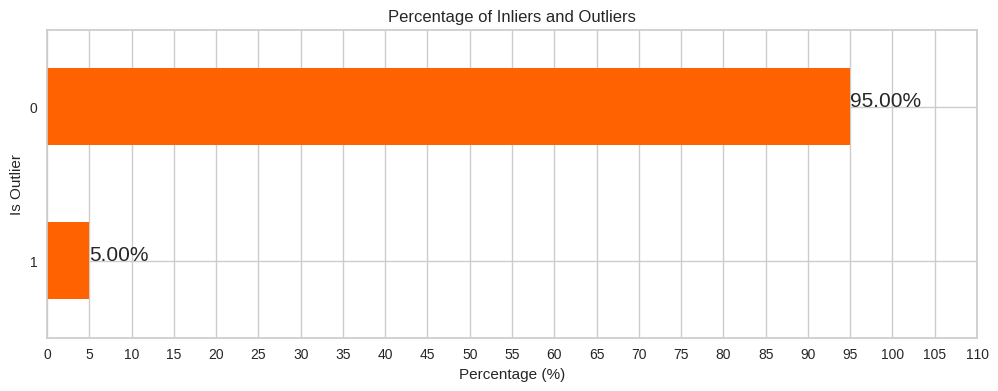

In [ ]:
# Calculer le pourcentage de valeurs aberrantes et non aberrantes
outlier_percentage = customer_df['is_outlier'].value_counts(normalize=True) * 100

# Représentation graphique du pourcentage de valeurs aberrantes et non aberrantes
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Ajout des étiquettes de pourcentage sur les barres
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

> Pour éviter que ces valeurs aberrantes n'affectent de manière significative la qualité des grappes, je les supprimerai de notre ensemble de données principal afin de le préparer à l'analyse par grappes.

In [ ]:
# Supprimer les valeurs aberrantes de l'ensemble de données principal
customer_df = customer_df[customer_df['is_outlier'] == 0]

# Supprimer les colonnes 'outlier_scores' et 'is_outlier'
customer_df = customer_df.drop(columns=['outlier_scores', 'is_outlier'])

# Réinitialiser l'index des données nettoyées
customer_df.reset_index(drop=True, inplace=True)

In [ ]:
customer_df.shape

(104992, 15)

## Analyse de corrélation

Avant de procéder au regroupement KMeans, il est essentiel de vérifier la corrélation entre les caractéristiques de notre ensemble de données. La présence d'une multicolinéarité, où les caractéristiques sont fortement corrélées, peut potentiellement affecter le processus de clustering en ne permettant pas au modèle d'apprendre les modèles sous-jacents réels dans les données.


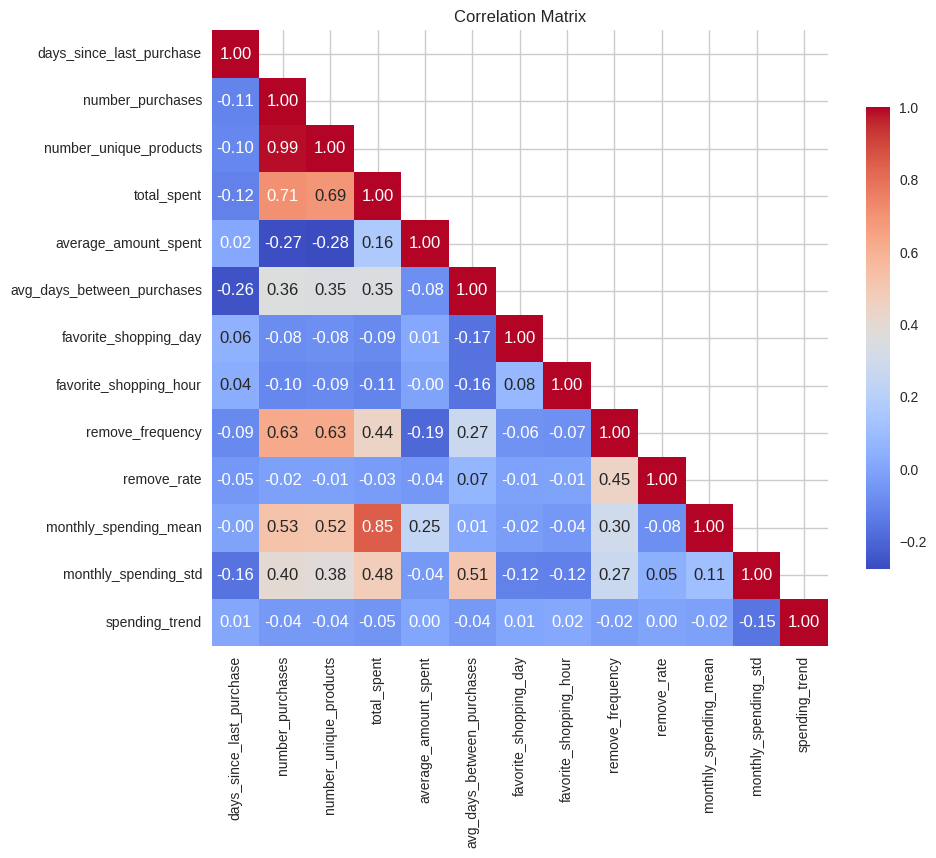

In [ ]:
# Calculer la matrice de corrélation en excluant la colonne "user_id".
corr_matrix = customer_df.drop(['user_id','number_events'], axis=1).corr()

# Créer un masque pour le triangle supérieur
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Tracer la carte thermique
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .75})

plt.title('Correlation Matrix')
plt.show()

En examinant la carte thermique, nous pouvons voir que certaines paires de variables ont des corrélations élevées, ce qui indiquent que ces variables évoluent étroitement ensemble, par exemple :

'number_unique_products' et 'number_purchases'

'total_spent' et 'number_purchases'

'number_purchases' et 'remove_frequency'

'total_spent' et 'monthly_spending_mean'

> Avant de passer aux étapes suivantes, nous pouvons utiliser des techniques de réduction de la dimensionnalité telles que l'ACP. Ces techniques permettent de neutraliser l'effet de la multicolinéarité en transformant les caractéristiques corrélées en un nouvel ensemble de variables non corrélées, en préservant la majeure partie de la variance des données d'origine.


## Mise à l'échelle des caractéristiques

Avant de procéder au clustering et à la réduction de la dimensionnalité, il est impératif de mettre nos caractéristiques à l'échelle. Cette étape revêt une importance significative, en particulier dans le contexte des algorithmes basés sur la distance tels que les K-means et les méthodes de réduction de la dimensionnalité qui dépend de la variation des données telles que l'ACP.

Pour garantir une influence équilibrée sur le modèle et révéler les véritables tendances des données, je vais normaliser nos données, c'est-à-dire transformer les caractéristiques pour qu'elles aient une moyenne de 0 et un écart-type de 1.

In [ ]:
customer_df_scaled = customer_df.copy()

# Colonnes qui ont besoin d'être mis à l'échelle
columns_to_scale = customer_df.columns.difference(['user_id', 'favorite_shopping_day'])

# Appliquer StandardScaler aux colonnes sélectionnées
scaler = StandardScaler()
customer_df_scaled[columns_to_scale] = scaler.fit_transform(customer_df_scaled[columns_to_scale])

customer_df_scaled.head()

,user_id,days_since_last_purchase,number_events,number_purchases,number_unique_products,total_spent,average_amount_spent,avg_days_between_purchases,favorite_shopping_day,favorite_shopping_hour,remove_frequency,remove_rate,monthly_spending_mean,monthly_spending_std,spending_trend
0,9794320,0.568599,0.769919,-0.534716,-0.531169,-0.755406,-0.450419,-0.347604,0,-1.458966,1.089150,1.904172,-0.757062,-0.260749,0.026758
1,10079204,1.003861,-0.728608,-0.752620,-0.760666,-0.434777,0.512151,-0.347604,2,-0.487167,-0.657128,-1.006373,-0.349044,-0.260749,0.026758
2,12055855,-0.004114,-0.541293,-0.534716,-0.531169,-0.661147,-0.355003,-0.347604,4,-0.098448,-0.495436,-0.090468,-0.637112,-0.260749,0.026758
3,12936739,-0.645552,-0.648330,-0.752620,-0.760666,-0.335146,0.713861,-0.347604,4,-1.070246,-0.560113,0.432907,-0.222257,-0.260749,0.026758
4,15400971,0.156246,-0.621571,-0.643668,-0.645917,-0.193024,0.413109,-0.347604,4,-0.098448,-0.560113,-0.166793,-0.041399,-0.260749,0.026758


In [ ]:
idx = ["mean", "std"]

pd.DataFrame(customer_df_scaled).describe().round(2).loc[idx, :]

,user_id,days_since_last_purchase,number_events,number_purchases,number_unique_products,total_spent,average_amount_spent,avg_days_between_purchases,favorite_shopping_day,favorite_shopping_hour,remove_frequency,remove_rate,monthly_spending_mean,monthly_spending_std,spending_trend
mean,5.304387e+08,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,2.70,0.0,0.0,-0.0,-0.0,0.0,0.0
std,8.661082e+07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.95,1.0,1.0,1.0,1.0,1.0,1.0


## Réduction de la dimensionnalité

Dans cette étape, nous envisageons d'appliquer des techniques de réduction de la dimensionnalité pour simplifier nos données tout en conservant les informations essentielles. Parmi les différentes méthodes telles que PCA, KernelPCA, ICA, ISOMAP, TSNE et UMAP, je choisis PCA (Analyse en Composantes Principales) et KernelPCA. Voici pourquoi :

**PCA :** excellent point de départ car elle permet de capturer les relations linéaires dans les données, ce qui est particulièrement pertinent compte tenu de la multicolinéarité que nous avons identifiée dans notre ensemble de données.

Dans le cas où les premières composantes du PCA ne capturent pas une part significative de la variance, ce qui indique une perte d'informations essentielles, nous pourrions envisager d'explorer d'autres méthodes non linéaires.

**KernelPCA :** Cette méthode peut potentiellement fournir une approche plus nuancée de la réduction de la dimensionnalité, en capturant des modèles complexes que l'ACP pourrait manquer, bien qu'au prix d'un temps de calcul et d'une complexité accrus.





In [ ]:
# user_id comme colonne index
customer_df_scaled.set_index('user_id', inplace=True)
customer_df_scaled.drop('number_events', axis=1, inplace=True)

***PCA :***

In [ ]:
# Appliquer l'ACP
pca = PCA().fit(customer_df_scaled.values)

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

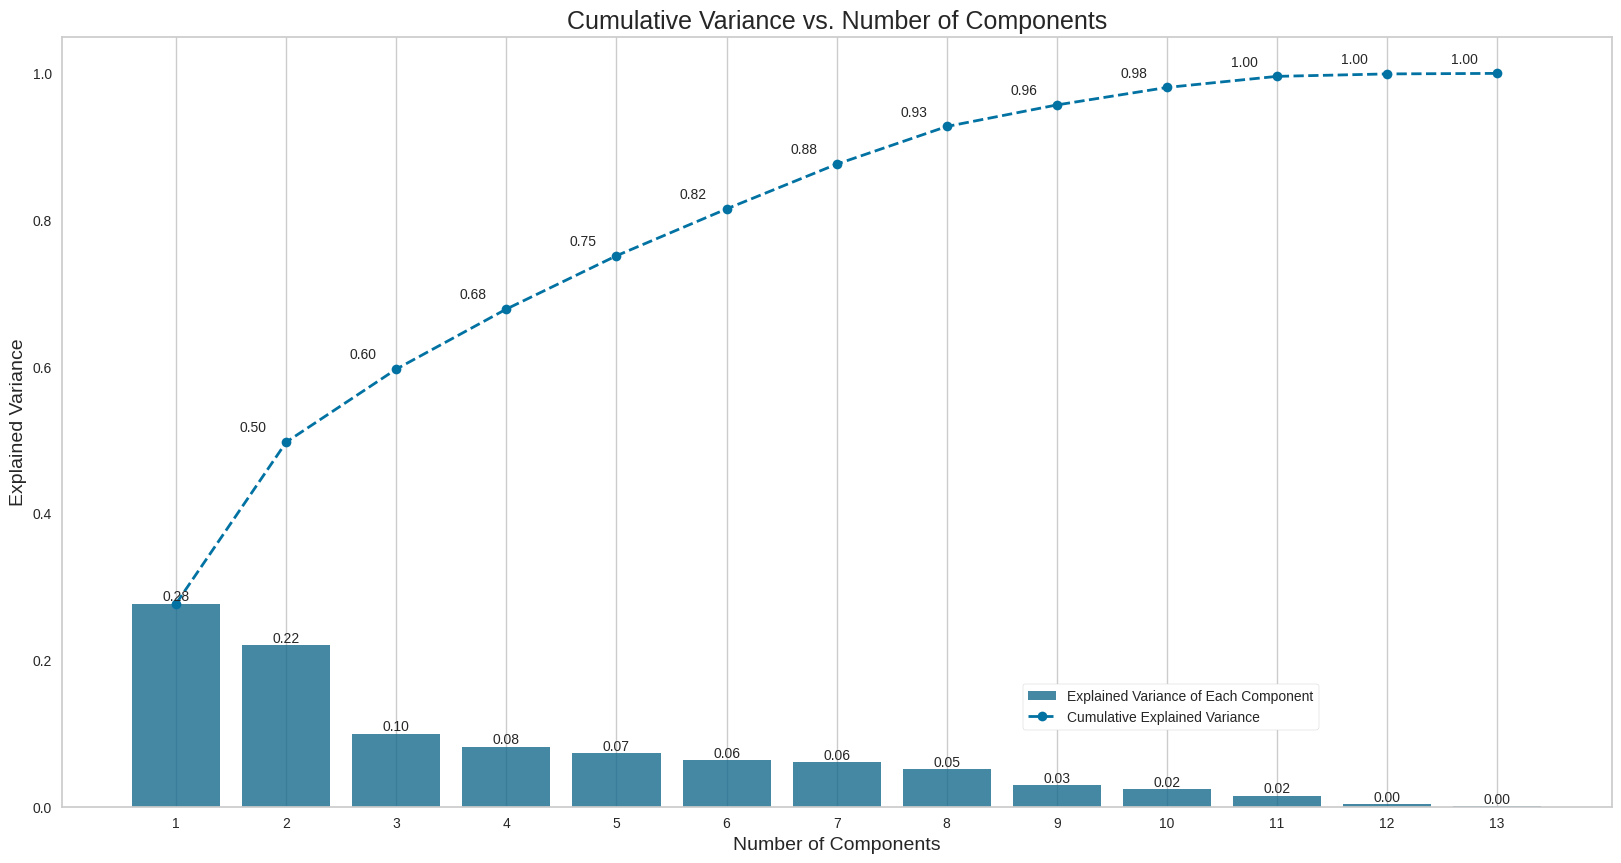

In [ ]:
plt.figure(figsize=(20, 10))

# Diagramme à barres de la variance expliquée de chaque composante
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      # color='#fcc36d',
                      alpha=0.8)

# Graphique linéaire de la variance expliquée cumulative
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--',
                    #  color='#ff6200',
                     linewidth=2)

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Personnaliser les ticks et la légende
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
          #  edgecolor='#ff6200'
           )

# Afficher les valeurs de variance pour les deux graphiques sur les courbes
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

On a la variance de chaque nouvelle composante, et en ligne la variance cumulée. On voit ici que près de 82% de la variance est comprise dans les 6 premières composantes, et 88% dans les 7 premières.

Pour choisir le nombre optimal de composantes, nous recherchons généralement un point où l'ajout d'une autre composante n'augmente pas de manière significative la variance expliquée cumulée, souvent appelé le "point de coude" de la courbe.

Le graphique montre que l'augmentation de la variance cumulée commence à ralentir après la septième composante (qui capture environ 88 % de la variance totale). Par conséquent, le maintien des sept premiers éléments pourrait être un choix équilibré.

In [ ]:
n_components = 7
pca = PCA(n_components=n_components)

# Ajustement et transformation des données originales dans le nouveau cadre de données de l'ACP
customer_df_pca = pca.fit_transform(customer_df_scaled)

# Création d'un nouveau dataframe à partir du dataframe de l'ACP, avec des colonnes intitulées PC1, PC2, etc.
customer_df_pca = pd.DataFrame(customer_df_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Aajout de l'index user_id au nouveau dataframe PCA
customer_df_pca.index = customer_df_scaled.index

customer_df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
user_id,,,,,,,
9794320,-1.220829,-2.541808,-1.507854,-1.039809,1.515307,-0.353740,-1.665926
10079204,0.735216,-1.507488,0.905215,0.239367,-0.510380,-0.208475,-0.825984
12055855,1.798332,0.160111,-0.466678,0.121503,-0.313818,0.059372,-0.167412
12936739,1.660055,0.205826,0.036527,0.948287,0.848472,0.390216,-0.738220
15400971,1.660360,0.314040,0.459204,0.363693,0.161962,0.022868,-0.186477


Intéressons nous maintenant à nos fameuses composantes. La formule de ce calcul nous est donnée par l'attribut `components_`

In [ ]:
# Créez le DataFrame de la composante ACP
pcs = pd.DataFrame(pca.components_)
pcs.columns = customer_df_scaled.columns
pcs.index = [f"PC{i}" for i in range(1, n_components+1)]
pcs.T

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
days_since_last_purchase,0.091535,-0.033721,0.196608,-0.389982,-0.092441,-0.378313,-0.426815
number_purchases,-0.347286,0.305301,-0.022782,-0.168636,-0.206200,0.016656,0.003322
number_unique_products,-0.342538,0.303979,-0.025563,-0.184903,-0.209640,0.013391,0.005504
total_spent,-0.329002,0.282082,0.316095,0.089625,0.096685,0.009228,0.030113
average_amount_spent,0.052069,-0.040800,0.504907,0.330186,0.507691,0.014119,0.028612
avg_days_between_purchases,-0.239461,0.088796,-0.286524,0.441313,-0.018979,0.130160,0.032417
favorite_shopping_day,0.628435,0.768287,-0.062776,0.094737,-0.002266,0.022988,-0.024411
favorite_shopping_hour,0.088072,-0.012298,0.051785,-0.262513,-0.019308,-0.129481,0.898391
remove_frequency,-0.263776,0.232802,-0.262730,-0.289924,0.302384,-0.047618,-0.032143
remove_rate,-0.036799,0.028378,-0.390269,-0.215590,0.722921,-0.101612,-0.035608


<Axes: >

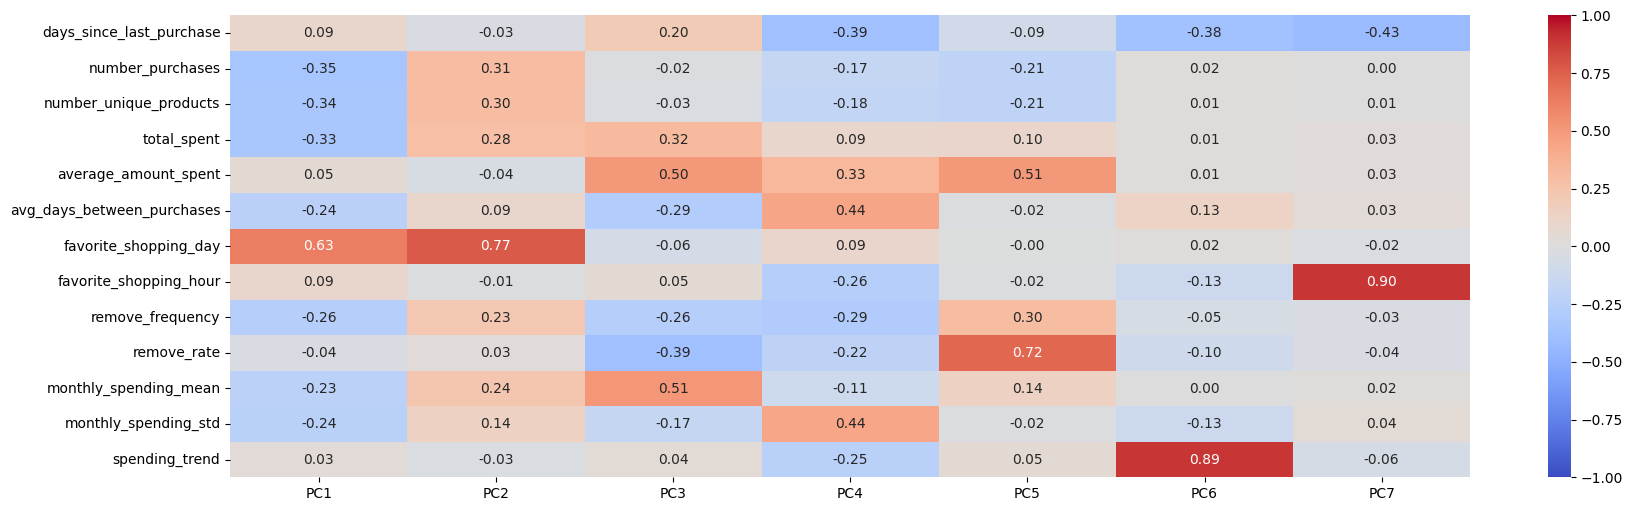

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [ ]:
# Graphe des corrélations pour les deux premières composantes principales
x_y = (0,1)
correlation_graph_interactive(pca, x_y, customer_df_scaled.columns)

D'après la heatmap et le graph de correlation, les variables les plus corrélées positivement à PC1 sont :
'number_purchases' ;
'number_unique_products' ;
'total_spent';
 mais on a aussi la variable 'favorite_shopping_day' qui est corrélée négativement à PC1.
 Quant à PC2, la variable la plus corrélées est 'favorite_shopping_day'.

In [ ]:
x_y = (2,3)
correlation_graph_interactive(pca, x_y, customer_df_scaled.columns, labels=True)

D'après la heatmap et le graph de correlation, les variables les plus corrélées positivement à PC3 sont :
'remove_rate' ;
et pour les variables corrélées négativement on a 'monthly_spending_mean'; 'average_amount_spent'.
 Quant à PC4, la variable la plus corrélée positivement est
'days_since_last_purchase' and négativement on a 'avg_days_between_purcahses'; 'monthly_spending_std'; 'average_amout_spent'.

***KernelPCA :***

L'ACP à noyau implique le calcul d'une matrice à noyau, qui peut nécessiter une grande quantité de mémoire. La matrice du noyau a une taille de 𝑁×𝑁 où 𝑁 est le nombre d'échantillons. Dans notre cas, la matrice du noyau aurait la taille suivante
(104 992×104 992) éléments.
Le calcul des valeurs propres et des vecteurs propres pour une matrice de noyau aussi grande est très exigeant et a provoqué un plantage en raison du dépassement des capacités de traitement de ma machine.

Je vais donc utiliser deux stratégies pour traiter notre ensemble de données :
1. Utiliser un petit sous-ensemble de données pour déterminer le nombre optimal de composants à l'aide de KernelPCA
2. Utiliser une méthode de noyau approximatif :

    Une fois que j'ai déterminé le nombre optimal de composantes à l'aide de KernelPCA, on va transformer l'ensemble de notre jeu de données en utilisant la méthode de noyau approximatif adéquate pour en réduire les dimensions. Le choix de cette méthode dépend du kernel selectionné comme meilleur paramètre lors de la GridSearch.
    
    On va ensuite utiliser cet ensemble de données transformé pour d'autres analyses, telles que le regroupement à l'aide de KMeans.

> ***RBFSampler*** permet d'effectuer des transformations non linéaires similaires à celles de KernelPCA. Il approxime le mappage des caractéristiques d'un noyau RBF (Radial Basis Function) à l'aide de caractéristiques aléatoires de Fourier, ce qui permet d'appliquer des algorithmes linéaires à des données qui sont mappées dans un espace de plus grande dimension, de manière similaire à l'effet de KernelPCA.

In [ ]:
# 1.
# J'utiliserai un sous-ensemble aléatoire plus petit de nos données pour effectuer l'ACP à noyau.
subset_size = 1000
subset_df = customer_df_scaled.sample(n=subset_size, random_state=42)

# Define a range of parameters
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.01, 0.1, 1, 10],
    'degree': [2, 3, 4]
}

# Scoreur personnalisé pour utiliser la variance expliquée
def explained_variance_scorer(estimator, X):
    transformed = estimator.fit_transform(X)
    explained_variance = np.var(transformed, axis=0).sum() / np.var(X, axis=0).sum()
    return explained_variance

# Initialiser KernelPCA
kpca = KernelPCA(fit_inverse_transform=True, random_state=42)

# Recherche en grille avec validation croisée
grid_search = GridSearchCV(kpca, param_grid, scoring=explained_variance_scorer, cv=3, verbose=1)
grid_search.fit(subset_df)

best_params = grid_search.best_params_


In [ ]:
# Best parameters
print("Best parameters:", best_params)

Best parameters: {'degree': 4, 'gamma': 10, 'kernel': 'poly'}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_kernel_pca.py:415: LinAlgWarning: Ill-conditioned matrix (rcond=2.64138e-24): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


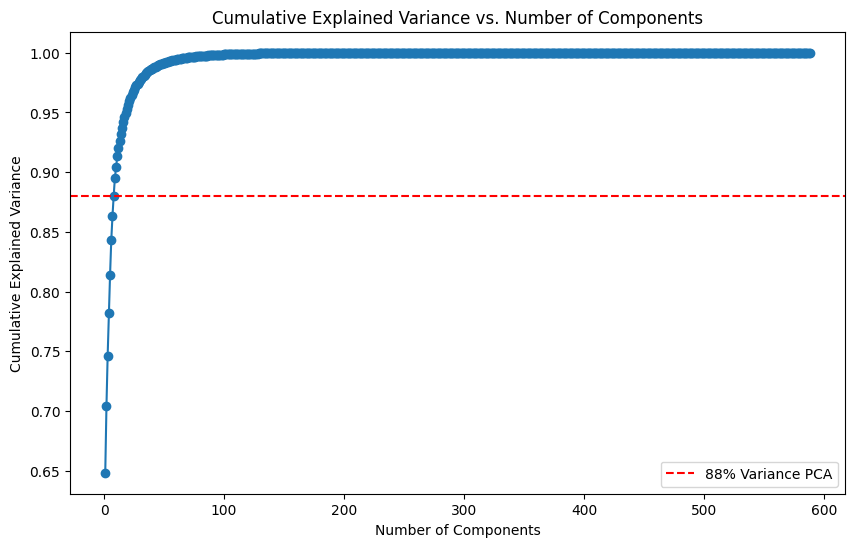

In [ ]:
# Appliquer KernelPCA
kernel_pca = KernelPCA(kernel=best_params['kernel'],
                 gamma=best_params.get('gamma', None),
                 degree=best_params.get('degree', None),
                 fit_inverse_transform=True,
                 random_state=42)
subset_kpca = kernel_pca.fit(subset_df)

# Valeurs propres
eigenvalues = kernel_pca.eigenvalues_

# Variance expliquée
explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Tracer la variance expliquée cumulative
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.axhline(y=0.88, color='r', linestyle='--', label='88% Variance PCA')
plt.legend()
plt.show()


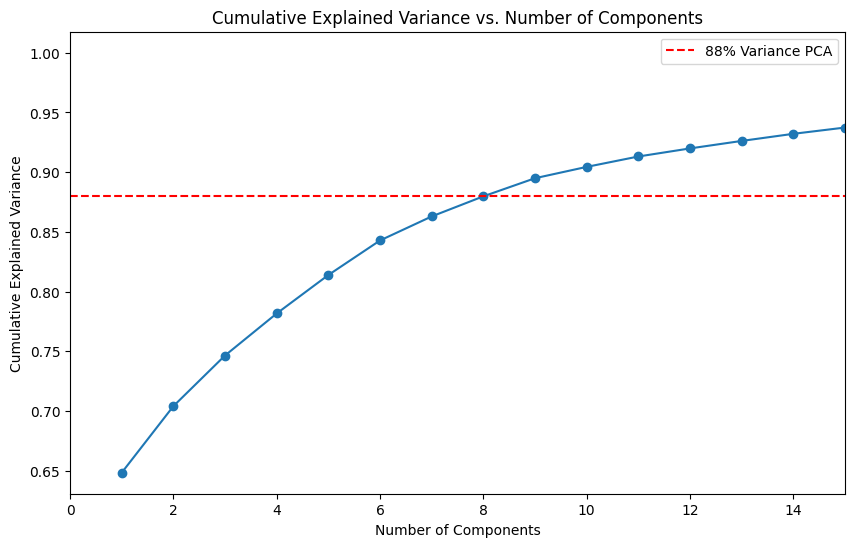

In [ ]:
# ZOOM IN
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlim(0, 15)
plt.axhline(y=0.88, color='r', linestyle='--', label='88% Variance PCA')
plt.legend()
plt.show()

On a la variance de chaque nouvelle composante, la variance cumulée. On voit ici que 88% de la variance est atteinte dans les 8 premières composantes.
On se contentera de garder le nombre de composantes qui nous permet d'atteindre 88% comme pour le PCA. Par conséquent, le maintien des huit premiers éléments pourrait être un choix équilibré.

Puisque le meilleur noyau est polynomial (poly), on va utiliser **PolynomialCountSketc**h** de sklearn.kernel_approximation comme méthode approximative pour KernelPCA. PolynomialCountSketch fournit une approximation du noyau polynomial en utilisant des caractéristiques de Fourier aléatoires, et convient aux grands ensembles de données.

In [ ]:
# Si le meilleur noyau était 'rbf'

# optimal_components = 8
# # Apply RBFSampler with the optimal number of components (e.g., 7)
# rbf_sampler = RBFSampler(n_components=optimal_components, gamma=0.1)
# customer_df_rbf = rbf_sampler.fit_transform(customer_df_scaled)

# # Convert the transformed data back to a DataFrame
# customer_df_kernel = pd.DataFrame(customer_df_rbf, columns=[f'Feature{i+1}' for i in range(optimal_components)])

# # Maintenant customer_df_kernel contient la transformation non linéaire similaire à KernelPCA.
# customer_df_kernel.head()


In [ ]:
# 2. Appliquer la méthode de noyau approximatif
optimal_components = 8

# Define the PolynomialCountSketch based on the best parameters
poly_sketch = PolynomialCountSketch(degree=4, gamma=10, n_components=100, random_state=42)

# Apply the PolynomialCountSketch and then PCA
pipeline = Pipeline([
    ('poly_sketch', poly_sketch),
    ('pca', PCA(n_components=optimal_components, random_state=42))
])

# Fit and transform the full dataset
customer_df_poly_pca = pipeline.fit_transform(customer_df_scaled.values)

# Convert the transformed data back to a DataFrame
customer_df_kernel = pd.DataFrame(customer_df_poly_pca, columns=[f'Feature{i+1}' for i in range(optimal_components)])

# Aajout de l'index user_id au nouveau dataframe PCA
customer_df_kernel.index = customer_df_scaled.index

# customer_df_poly_pca is now your transformed dataframe
print(customer_df_kernel.shape)

(104992, 8)


In [ ]:
customer_df_kernel.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8
0,11796.502146,-14787.802002,-16696.910135,-219.943228,8925.007085,11587.170294,-3758.310176,-3657.416325
1,10492.626921,-14942.677647,-16513.552720,-875.935773,7998.956843,10745.781747,-3210.299787,-3256.689448
2,10901.995615,-16858.299779,-17546.508961,-887.662483,9823.192591,10060.568830,-53.162418,-205.686205
3,7602.553872,-15827.951484,-13481.904991,315.291577,9707.651985,10360.985928,-5177.118175,1595.753820
4,10982.405826,-17325.061989,-17888.427049,-2140.669108,7501.554205,7628.645908,-311.471131,-263.687625
